- Load necessary module

In [1]:
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from scipy.stats import multinomial
from collections import OrderedDict

- Load model that defined in channel realization

In [2]:
np.random.seed(1)
mat = io.loadmat('tempNs4.mat')
model = {}
model['H'] = mat['H']
# model['Wopt'] = mat['Wopt']
# model['Fopt'] = mat['Fopt']
# model['Ns'] = mat['Ns'][0,0] ## need to change nb of stream in channel realization, this case 1
model['Ns'] = 4
model['Nt'] = mat['Nt'][0,0]
model['Nr'] = mat['Nr'][0,0]
model['Nc'] = mat['Nc'][0,0]
model['Nray'] = mat['Nray'][0,0]
model['realization'] = mat['realization'][0,0]
model['At'] = mat['At']
model['Ar'] = mat['Ar']
model['Nrf'] = 4

In [3]:
for key in model:
    print(key)

H
Ns
Nt
Nr
Nc
Nray
realization
At
Ar
Nrf


Load values of phase shifter included:
- nb_bit: number of bit
- nb_ps: number of phase shifter in the system
- nb_state: number of state in each phase shifter (2^nb_bit)

# Cross Entropy Beamforming

### Helper function for Cross entropy Beamforming

In [4]:
def phase_shifter(n_bit,n_ant):
    """
    Define phase shifter with N bits resolution
    
    Arguments:
    N -- number of bits resolutions
    
    Returns:
    y -- python dictionnary of phase shifter: index of state and value of phase
    """
    nb_state = 2**n_bit
    w = np.exp(1j*2*np.pi/nb_state)
    ps = np.zeros(nb_state,dtype=complex)
    for i in range(nb_state):
        ps[i] = w**i/np.sqrt(n_ant)
    return np.around(ps, decimals=3)

def generate_candidat(S,model,phase_value,ps_system_proba):
    """
    generate S candidates from the previous pmf
    
    Arguments: 
    S -- Number of candidates to generate
    model -- channel model
    phase_value -- possible phase shifted value
    ps_system_proba -- pmf of phase shifters
    
    Returns
    F_rf -- S analog precoder system
    """
    F_rf = np.zeros((S,model['Nt'],model['Nrf']),dtype=complex)
    for i in range(S):
        for j in range(model['Nt']):
            for k in range(model['Nrf']):
                F_rf[i,j,k] = np.random.choice(phase_value, 1, p=ps_system_proba[j,k,:])
    return F_rf

def compute_Fbb(F_rf,model):
    """
    Compute baseband precoder base on the effective channel (Heq = H*Frf)
    
    Arguments:
    F_rf -- analog precoder
    model -- channel model
    
    Returns:
    F_bb -- S baseband precoder
    """
    S = F_rf.shape[0]
    channel_eq = np.zeros((S,model['Nr'],model['Nrf']),dtype=complex)
    F_bb = np.zeros((S,model['Nrf'],model['Ns']),dtype=complex)
    channel_index = 0 ### need to adjust 
    for i in range(S):
        channel_eq[i,:,:] =  model['H'][:,:,channel_index]@F_rf[i,:,:]
        U, s, V = np.linalg.svd(channel_eq[i,:,:], full_matrices=True)
        V = V.conj().T
        F_bb[i,:,:] = V[0:model['Nt'],0:model['Ns']]
        F_bb[i,:,:] = np.sqrt(model['Ns'])*F_bb[i,:,:]/np.linalg.norm(F_rf[i,:,:]@F_bb[i,:,:],'fro')
    return F_bb

def optimal_beamformer(model, channel_index):
    """
    Compute the optimal beamformer by SVD
    
    Arguments:
    model -- channel model
    channel_index -- index in 1000 realization channel
    
    Returns:
    Fopt -- optimal precoder
    Wopt -- optimal combiner
    """
    Wopt = np.zeros((model['Nr'],model['Ns']),dtype=complex)
    Fopt = np.zeros((model['Nt'],model['Ns']),dtype=complex)
    U, s, V = np.linalg.svd(model['H'][:,:,channel_index], full_matrices=True)
    V = V.conj().T
    Fopt = V[0:model['Nt'],0:model['Ns']]
    Wopt = U[0:model['Nr'],0:model['Ns']]
    return Fopt, Wopt


def update_pmf(F_elites,phase_value,nb_elite,R_elite):
    """
    Update new phase shifters's pmf base on previous candidates's results
    
    Arguments:
    F_elites -- elites analog precoder
    phase_value -- phase shift value
    nb_elite -- number of elites 
    
    Returns:
    ps_system_proba -- pmf of phase shifter
    """
    alpha = 0.9
    nb_state = phase_value.shape[0]
    stat_count = np.zeros(nb_state)
    assign = np.zeros(nb_elite)
    weight = R_elite/np.mean(R_elite)
    for i in range(model['Nt']):
        for j in range(model['Nrf']):
            for k in range(nb_state):
                assign = F_elites[:,i,j] == phase_value[k]
                proba_est = np.sum(assign*weight)/nb_elite
#                 proba_est = np.sum(assign)/nb_elite
                ps_system_proba[i,j,k] = alpha*proba_est + (1-alpha)*ps_system_proba[i,j,k] 
    return ps_system_proba

def data_rate(Ns,SNR,W,H,F):
    """
    Compute the data rate of the beamforming system
    
    Arguments:
    Ns -- number of stream
    SNR -- Signal to noise ratio
    W -- combiner
    H -- channel
    F -- precoder
    
    Returns:
    R -- data rate
    """
    R = np.log2(np.linalg.det(np.eye(Ns)+SNR/Ns*np.linalg.pinv(W)@H@F@F.conj().T@H.conj().T@W))
    return R.real

### Define Phase shiter

In [5]:
nb_bit = 2
nb_ps = model['Nt']*model['Nrf']
nb_ps
nb_state = 2**nb_bit

In [6]:
phase_value = phase_shifter(nb_bit,model['Nt'])
phase_value

array([ 0.125+0.   j,  0.   +0.125j, -0.125+0.   j, -0.   -0.125j])

Phase shifter system dimension is: NtxNrfxN_state

### Cross entropy beamforming Algorithm
 Step 1: Randomly generate S candidate analog beamformers

 Step 2: Compute S corresponding digital precoders Fbb based on the effective channel Heq = HFrf

 Step 3: Calculate the achievable sum-rate

 Step 4: Sort R in a descend order

 Step 5: Select elites as Frf_1, Frf_2, ..., Frf_elite

 Step 6: Update new pmf for each phase shifter

In [7]:
channel_index = 0
model['Fopt'], model['Wopt'] = optimal_beamformer(model,channel_index)


In [8]:
def CE_beamforming(nb_elite,S,nb_iterate,model,nb_bit,ps_system_proba,channel_index,SNR):
    """
    Hybrid beamforming by Cross-entropy method
    
    """
    Fopt, Wopt = model['Fopt'],model['Wopt']
    proba_evo = np.copy(ps_system_proba[0,0,:])
    print(proba_evo)
    relative_std = 1000 # initialize high value of relative standard deviation
    i = 0
    while ((i<nb_iterate) and (relative_std>3)):
        print(i)
        F_rf = generate_candidat(S,model,phase_value,ps_system_proba)
        F_bb = compute_Fbb(F_rf,model)
        R = np.zeros((S))
        for j in range(S):
            R[j] = data_rate(model['Ns'],SNR,Wopt,model['H'][:,:,channel_index],F_rf[j,:,:]@F_bb[j,:,:])
        R_sort_index = np.argsort(R)[::-1][:nb_elite]
        if i==0:
            R_max = R[R_sort_index[0]]
        else:
            R_max = np.append(R_max,R[R_sort_index[0]])
        F_elites = F_rf[R_sort_index,:,:]
        Frf_max = F_rf[R_sort_index[0],:,:]
        Fbb_max = F_bb[R_sort_index[0],:,:]
        ps_system_proba = update_pmf(F_elites,phase_value,nb_elite,R[R_sort_index])
        proba_evo = np.vstack((proba_evo,ps_system_proba[0,0,:]))
        if i>=5:
            R_max_normalize = R_max-np.min(R_max) ## Need to review
            relative_std = 100*np.std(R_max_normalize[i-5:i])/np.mean(R_max_normalize[i-5:i])
            print(relative_std)
        i +=1
    output = {}
    output['R_max'] = R_max
    output['Frf_max'] = Frf_max
    output['Fbb_max'] = Fbb_max
    output['nb_ite'] = i
    output['proba_evo'] = proba_evo
    output['ps_system_proba'] = ps_system_proba
    return output

In [9]:
nb_elite = 40
S = 200
channel_index = 0
nb_iterate = 30
ps_system_proba = np.ones((model['Nt'],model['Nrf'],nb_state))*(1/nb_state)
SNR = 10**(10/10)
CE_result = CE_beamforming(nb_elite,S,nb_iterate,model,nb_bit,ps_system_proba,channel_index,SNR)

[0.25 0.25 0.25 0.25]
0
1
2
3
4
5
75.39862673978143
6
46.37945006145996
7
16.330284530011088
8
17.226051050970316
9
33.78736022942869
10
31.77998800405009
11
43.87542362054902
12
37.69499298507446
13
32.10030118081823
14
29.054680075367788
15
20.983265438534808
16
17.80436452211304
17
14.54499362713027
18
12.155712444877567
19
9.369396116049046
20
8.238729385454366
21
7.266077935322609
22
6.5125043159369795
23
6.215181588187443
24
4.956727938072452
25
4.327240153041734
26
4.747467199691131
27
4.142695159158171
28
3.5944385920218727
29
2.611192681300811


In [10]:
np.sum([0.251, 0.295, 0.337, 0.117])

1.0

In [11]:
# Evolution of pmf of 1 phase shifter
np.around(CE_result['proba_evo'], decimals=3)

array([[0.25 , 0.25 , 0.25 , 0.25 ],
       [0.295, 0.226, 0.295, 0.184],
       [0.326, 0.153, 0.345, 0.175],
       [0.305, 0.081, 0.486, 0.128],
       [0.346, 0.076, 0.453, 0.124],
       [0.304, 0.052, 0.565, 0.078],
       [0.229, 0.094, 0.601, 0.077],
       [0.181, 0.098, 0.602, 0.119],
       [0.152, 0.119, 0.693, 0.035],
       [0.061, 0.101, 0.813, 0.025],
       [0.028, 0.032, 0.937, 0.003],
       [0.026, 0.003, 0.971, 0.   ],
       [0.003, 0.   , 0.997, 0.   ],
       [0.   , 0.   , 1.   , 0.   ],
       [0.   , 0.   , 1.   , 0.   ],
       [0.   , 0.   , 1.   , 0.   ],
       [0.   , 0.   , 1.   , 0.   ],
       [0.   , 0.   , 1.   , 0.   ],
       [0.   , 0.   , 1.   , 0.   ],
       [0.   , 0.   , 1.   , 0.   ],
       [0.   , 0.   , 1.   , 0.   ],
       [0.   , 0.   , 1.   , 0.   ],
       [0.   , 0.   , 1.   , 0.   ],
       [0.   , 0.   , 1.   , 0.   ],
       [0.   , 0.   , 1.   , 0.   ],
       [0.   , 0.   , 1.   , 0.   ],
       [0.   , 0.   , 1.   , 0.   ],
 

Data rate evolution: [18.49173462 18.62767954 19.53021904 19.78655603 19.48037543 19.94239769
 19.47736777 19.95975792 20.8134316  20.89508562 22.2976728  22.97555121
 23.85137956 24.64217739 25.42920448 26.01129276 26.67187261 27.24226278
 27.45491916 28.09889133 28.566543   28.8622457  29.234892   29.57911261
 29.84690777 30.40561461 30.4605388  30.71522841 30.68034258 30.88717701]
Number of iteration: 30
Phase shifter pmf[[0.25  0.25  0.25  0.25 ]
 [0.295 0.226 0.295 0.184]
 [0.326 0.153 0.345 0.175]
 [0.305 0.081 0.486 0.128]
 [0.346 0.076 0.453 0.124]
 [0.304 0.052 0.565 0.078]
 [0.229 0.094 0.601 0.077]
 [0.181 0.098 0.602 0.119]
 [0.152 0.119 0.693 0.035]
 [0.061 0.101 0.813 0.025]
 [0.028 0.032 0.937 0.003]
 [0.026 0.003 0.971 0.   ]
 [0.003 0.    0.997 0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [0. 

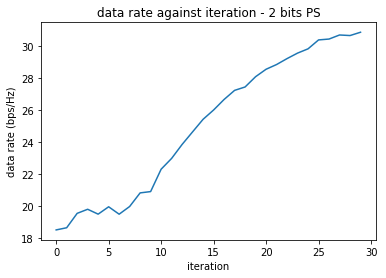

In [12]:
print('Data rate evolution: ' + str(CE_result['R_max']))
plt.plot(CE_result['R_max'])
plt.title('data rate against iteration - 2 bits PS')
plt.ylabel('data rate (bps/Hz)')
plt.xlabel('iteration')
print('Number of iteration: ' + str(CE_result['nb_ite']))
print('Phase shifter pmf' + str(np.around(CE_result['proba_evo'], decimals=3)))

Test:

2 bits -- 17.56 bps/Hz - 16 iterate

3 bits -- 17.68 bps/Hz - 18 iterate

4 bits -- 17.71 bps/Hz - 18 iterate

6 bits -- 17.68 bps/Hz - 19 iterate

# Digital Beamforming

In [13]:
R_o = data_rate(model['Ns'],SNR,model['Wopt'],model['H'][:,:,channel_index],model['Fopt'])
print('Data rate by digital beamforming: ' + str(R_o))

Data rate by digital beamforming: 33.972702082410066


In [49]:
# Normalize condition
x = np.linalg.norm(CE_result['Frf_max']@CE_result['Fbb_max'],'fro')
print("Ns", model['Ns'] , "   Frobenius norm FRF*FBB=", x**2)

Ns 4    Frobenius norm FRF*FBB= 4.0


# OMP Beamforming

In [66]:
def OMP(_Fopt,_NRF,_At):
    """
    Orthogonal matching pursuit for hybrid beamforming
    
    """
    _FRF = np.empty((_At.shape[0],0))
    _Fres = _Fopt
    for k in range(_NRF):
        PU = _At.conj().T@_Fres
        ind = np.argmax(np.sum((np.absolute(PU))**2,axis=1))
        _FRF = np.append(_FRF,_At[:,[ind]],axis=1)
        _FBB = (np.linalg.pinv(_FRF))@_Fopt
        _Fres = (_Fopt-_FRF@_FBB)/np.linalg.norm((_Fopt-_FRF@_FBB),'fro')
#         _Fres = (_Fopt-_FRF@_FBB)
    _FBB = np.sqrt(model['Ns'])*_FBB/np.linalg.norm(_FRF@_FBB,'fro')
    return _FRF,_FBB

In [67]:
FRF_omp, FBB_omp = OMP( model['Fopt'][:,:,channel_index], model['Nrf'], model['At'][:,:,channel_index] ) 


In [71]:
# Normalize FBB_omp
x = np.linalg.norm(FRF_omp@FBB_omp,'fro')
print("Ns", model['Ns'] , "   Frobenius norm FRF*FBB=", x**2)

Ns 4    Frobenius norm FRF*FBB= 4.0


In [59]:
R_omp = data_rate(model['Ns'],SNR,model['Wopt'],model['H'][:,:,channel_index],FRF_omp@FBB_omp)
print("Data rate by OMP: " + str(R_omp))

ValueError: shapes (16,1000,4) and (16,64) not aligned: 4 (dim 2) != 16 (dim 0)

In [69]:
model['Wopt'] = mat['Wopt']
model['Fopt'] = mat['Fopt']
SNR_dB = np.arange(-30,15,5)
OMP_rate = np.zeros((SNR_dB.shape[0]))
sum_OMP_rate = np.zeros((SNR_dB.shape[0]))
for channel_index in range(100):
#     print('index: ' + str(channel_index))
    FRF_omp, FBB_omp = OMP( model['Fopt'][:,:,channel_index], model['Nrf'], model['At'][:,:,channel_index] )
    for i in range(SNR_dB.shape[0]):
        OMP_rate[i] = data_rate(model['Ns'],10**(SNR_dB[i]/10),model['Wopt'][:,:,channel_index],model['H'][:,:,channel_index],FRF_omp@FBB_omp)
    sum_OMP_rate = sum_OMP_rate + OMP_rate
#     print(OMP_rate)

In [70]:
sum_OMP_rate/100

array([ 0.22317937,  0.65307923,  1.7242831 ,  3.89130729,  7.38210255,
       12.0446525 , 17.52735967, 23.49692577, 29.73026376])

### Quantize omp beamforming

In [74]:
def quantize_Frf(model,n_bit,F_rf,channel_index):
    """
    Quantize precoder for low resolutioin phase shifter
    
    """
    q = 2*np.pi/2**n_bit
    amplitude = 1/np.sqrt(model['Nt'])
    Frf_angle = np.angle(F_rf)
    angle_quantized = q * np.round(Frf_angle/q)
    Frf_quantized = amplitude*np.exp(1j*angle_quantized)
    Frf_quantized = np.around(Frf_quantized, decimals=3)
    
    channel_eq =  model['H'][:,:,channel_index]@Frf_quantized
    U, s, V = np.linalg.svd(channel_eq, full_matrices=True)
    V = V.conj().T
    F_bb = V[0:model['Nt'],0:model['Ns']]
    F_bb = np.sqrt(model['Ns'])*F_bb/np.linalg.norm(Frf_quantized@F_bb,'fro')
    
    return Frf_quantized, F_bb

In [19]:
Frf_quantize, Fbb_quantize = quantize_Frf(model,nb_bit,FRF_omp,channel_index)

In [20]:
R_omp_quantized = data_rate(model['Ns'],SNR,model['Wopt'],model['H'][:,:,channel_index],Frf_quantize@Fbb_quantize)
print('Data rate by OMP with quantization: ' + str(R_omp_quantized))

Data rate by OMP with quantization: 29.6707305294086


In [75]:
model['Wopt'] = mat['Wopt']
model['Fopt'] = mat['Fopt']
SNR_dB = np.arange(-30,15,5)
OMP_quan_rate = np.zeros((SNR_dB.shape[0]))
sum_OMP_quan_rate = np.zeros((SNR_dB.shape[0]))
for channel_index in range(100):
#     print('index: ' + str(channel_index))
    FRF_omp, FBB_omp = OMP( model['Fopt'][:,:,channel_index], model['Nrf'], model['At'][:,:,channel_index] )
    Frf_quantize, Fbb_quantize = quantize_Frf(model,nb_bit,FRF_omp,channel_index)
    for i in range(SNR_dB.shape[0]):
        OMP_quan_rate[i] = data_rate(model['Ns'],10**(SNR_dB[i]/10),model['Wopt'][:,:,channel_index],model['H'][:,:,channel_index],Frf_quantize@Fbb_quantize)
    sum_OMP_quan_rate = sum_OMP_quan_rate + OMP_quan_rate
#     print(OMP_quan_rate)

In [76]:
sum_OMP_quan_rate/100

array([ 0.15360772,  0.46233855,  1.28936884,  3.13826287,  6.41532018,
       11.08009538, 16.72319897, 22.90968806, 29.3595054 ])

In [77]:
# Normalize condition
x = np.linalg.norm(Frf_quantize@Fbb_quantize,'fro')
print("Ns", model['Ns'] , "   Frobenius norm FRF*FBB=", x**2)

Ns 4    Frobenius norm FRF*FBB= 4.0


### Initialize pmf of phase shiter with OMP

In [22]:
phase_value

array([ 0.125+0.   j,  0.   +0.125j, -0.125+0.   j, -0.   -0.125j])

In [78]:
FRF_omp

array([[ 0.125     +0.        j,  0.125     +0.        j,
         0.125     +0.        j,  0.125     +0.        j],
       [-0.12249361+0.02490613j,  0.0389992 -0.11876053j,
         0.04452788-0.11680012j,  0.078783  +0.09704761j],
       [ 0.11507496-0.04881346j, -0.100665  -0.07410504j,
        -0.09327629-0.08321378j, -0.02569182+0.12233123j],
       [-0.10304154+0.07076327j, -0.10181287+0.07251993j,
        -0.1109822 +0.05751479j, -0.11116826+0.05715433j],
       [ 0.08687593-0.08987532j,  0.03713508+0.11935655j,
         0.01420747+0.12418997j, -0.11443888-0.0502866 j],
       [-0.06722641+0.10538316j,  0.12498468+0.00195703j,
         0.12110425+0.03096385j, -0.03308515-0.120542  j],
       [ 0.04488095-0.11666491j,  0.04085376-0.11813539j,
         0.07207278-0.10212989j,  0.07273412-0.10165996j],
       [-0.02073567+0.12326813j, -0.09949246-0.075672  j,
        -0.06975629-0.10372589j,  0.12476855-0.00760323j],
       [ 0.07368475-0.10097305j,  0.12420149+0.0141064 j,
      

In [79]:
Frf_quantize

array([[ 0.125+0.   j,  0.125+0.   j,  0.125+0.   j,  0.125+0.   j],
       [-0.125+0.   j,  0.   -0.125j,  0.   -0.125j,  0.   +0.125j],
       [ 0.125+0.   j, -0.125-0.   j, -0.125-0.   j,  0.   +0.125j],
       [-0.125+0.   j, -0.125+0.   j, -0.125+0.   j, -0.125+0.   j],
       [ 0.   -0.125j,  0.   +0.125j,  0.   +0.125j, -0.125-0.   j],
       [ 0.   +0.125j,  0.125+0.   j,  0.125+0.   j,  0.   -0.125j],
       [ 0.   -0.125j,  0.   -0.125j,  0.   -0.125j,  0.   -0.125j],
       [ 0.   +0.125j, -0.125-0.   j,  0.   -0.125j,  0.125+0.   j],
       [ 0.   -0.125j,  0.125+0.   j, -0.125+0.   j,  0.   -0.125j],
       [ 0.   +0.125j,  0.   -0.125j,  0.   +0.125j,  0.   -0.125j],
       [ 0.   -0.125j, -0.125-0.   j,  0.125+0.   j,  0.125+0.   j],
       [ 0.   +0.125j, -0.125+0.   j,  0.   -0.125j,  0.125+0.   j],
       [ 0.   -0.125j,  0.   +0.125j,  0.   -0.125j,  0.   +0.125j],
       [ 0.   +0.125j,  0.125+0.   j, -0.125+0.   j, -0.125+0.   j],
       [ 0.   -0.125j,  0.   -0.12

In [25]:
def initialize_pmf_omp(model,nb_bit,Frf_omp_quantize,phase_value,ratio):
    """
    Initialize pmf of phase shifter with solution getting by OMP
    
    """
    low_proba = 1/(2**nb_bit-1+ratio)
    high_proba = ratio*low_proba
    proba_init = np.zeros((model['Nt'],model['Nrf'],2**nb_bit))
    for i in range(phase_value.shape[0]):
        assign = Frf_quantize == phase_value[i]
        proba_init[:,:,i] = assign*high_proba + np.invert(assign)*low_proba
    return proba_init

### Cross entropy method with initialization by quantized OMP

In [26]:
ps_system_proba_omp = initialize_pmf_omp(model,nb_bit,Frf_quantize,phase_value,3)
ps_system_proba_omp

array([[[0.5       , 0.16666667, 0.16666667, 0.16666667],
        [0.5       , 0.16666667, 0.16666667, 0.16666667],
        [0.5       , 0.16666667, 0.16666667, 0.16666667],
        [0.5       , 0.16666667, 0.16666667, 0.16666667]],

       [[0.16666667, 0.16666667, 0.5       , 0.16666667],
        [0.16666667, 0.16666667, 0.5       , 0.16666667],
        [0.16666667, 0.16666667, 0.16666667, 0.5       ],
        [0.16666667, 0.5       , 0.16666667, 0.16666667]],

       [[0.5       , 0.16666667, 0.16666667, 0.16666667],
        [0.5       , 0.16666667, 0.16666667, 0.16666667],
        [0.16666667, 0.5       , 0.16666667, 0.16666667],
        [0.16666667, 0.16666667, 0.5       , 0.16666667]],

       ...,

       [[0.16666667, 0.16666667, 0.5       , 0.16666667],
        [0.16666667, 0.5       , 0.16666667, 0.16666667],
        [0.5       , 0.16666667, 0.16666667, 0.16666667],
        [0.5       , 0.16666667, 0.16666667, 0.16666667]],

       [[0.5       , 0.16666667, 0.16666667, 0.1666

In [27]:
nb_elite = 40
S = 200
channel_index = 0
nb_iterate = 30
ps_system_proba_omp = initialize_pmf_omp(model,nb_bit,Frf_quantize,phase_value,3)
SNR = 10**(10/10)
CE_result_omp = CE_beamforming(nb_elite,S,nb_iterate,model,nb_bit,ps_system_proba_omp,channel_index,SNR)

[0.5        0.16666667 0.16666667 0.16666667]
0
1
2
3
4
5
88.05438752071407
6
60.72815079789062
7
41.634515975193025
8
25.61682727185708
9
19.306509041061968
10
14.248647459870948
11
10.46304583620396
12
7.721965723449087
13
8.543498509788124
14
7.32992109167095
15
5.826138229418169
16
5.3686942809374205
17
3.915572882109656
18
3.9690874029264043
19
2.988366652719527


Data rate evolution: [22.01088009 22.50955584 23.08407548 24.90833952 25.8365326  26.57748656
 27.34725786 28.29943816 28.56568597 28.84893656 29.39678423 29.76781621
 30.3213286  30.33318879 30.73721946 31.12078629 31.05359079 31.35506419
 31.53976613 31.68924028]
Number of iteration: 20
Phase shifter pmf[[0.5   0.167 0.167 0.167]
 [0.52  0.157 0.167 0.156]
 [0.461 0.26  0.149 0.13 ]
 [0.539 0.137 0.175 0.149]
 [0.572 0.125 0.176 0.128]
 [0.53  0.08  0.196 0.194]
 [0.391 0.121 0.267 0.222]
 [0.444 0.169 0.162 0.224]
 [0.539 0.151 0.174 0.136]
 [0.503 0.196 0.152 0.149]
 [0.477 0.245 0.083 0.195]
 [0.588 0.181 0.098 0.133]
 [0.711 0.153 0.077 0.058]
 [0.904 0.06  0.03  0.006]
 [0.923 0.073 0.003 0.001]
 [0.947 0.053 0.    0.   ]
 [0.905 0.095 0.    0.   ]
 [0.99  0.01  0.    0.   ]
 [0.999 0.001 0.    0.   ]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]]


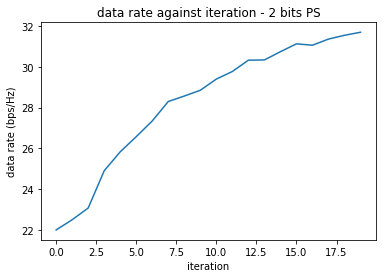

In [28]:
print('Data rate evolution: ' + str(CE_result_omp['R_max']))
plt.plot(CE_result_omp['R_max'])
plt.title('data rate against iteration - 2 bits PS')
plt.ylabel('data rate (bps/Hz)')
plt.xlabel('iteration')
print('Number of iteration: ' + str(CE_result_omp['nb_ite']))
print('Phase shifter pmf' + str(np.around(CE_result_omp['proba_evo'], decimals=3)))

In [29]:
# print(CE_result_omp['Frf_max'] == CE_result['Frf_max'])
# print(CE_result_omp['Frf_max'] == Frf_quantize)